https://zhuanlan.zhihu.com/p/666397976

In [8]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt


def exact_solution(a1,a2,x,y):
    u = np.sin(a1*np.pi*x)*np.sin(a2*np.pi*y)
    return u

class FCN(nn.Module):
    # 定义一个全连接神经网络（FCN）类
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh  # 使用双曲正切作为激活函数
        # 第一层全连接层，从输入层到隐藏层
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        # 中间隐藏层，可能有多层
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        # 最后一层全连接层，从隐藏层到输出层
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        # 定义网络的前向传播过程
        x = self.fcs(x)  # 通过第一层全连接层
        x = self.fch(x)  # 通过中间隐藏层
        x = self.fce(x)  # 通过最后一层全连接层
        return x

True value of k: 1


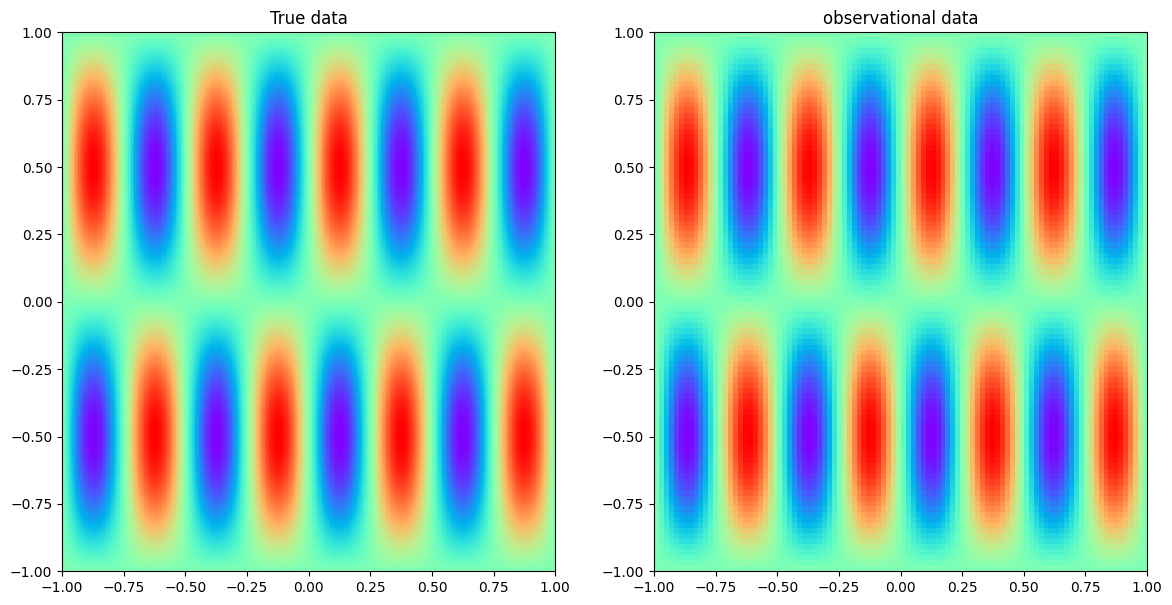

In [46]:
# 首先，创建一些带噪声的观测数据
torch.manual_seed(123)  # 设置随机种子，以确保结果的可重复性

k = 1  # 定义k
a1=1
a2=4

print(f"True value of k: {k}")  # 打印变量k的真实值

# x_obs = torch.rand(40).view(-1, 1)  # 生成40个随机观测x点，值在0到1之间
# y_obs = torch.rand(40).view(-1, 1)  # 生成40个随机观测y点，值在0到1之间
lin_num = 100
y = np.linspace(-1,1,lin_num)[:,None] #Y采样点
x = np.linspace(-1,1,lin_num)[:,None] #X采样点
X, Y = np.meshgrid(x,y)
u_obs = exact_solution(a1, a2, X, Y) #+ 0.04*torch.randn_like(t_obs)  # 生成观测数据。这里首先计算每个时间点的精确解，然后添加高斯噪声

y_test = torch.linspace(-1, 1, 300).view(-1, 1)  # 创建300个均匀分布的测试时间点，用于绘制精确解
x_test = torch.linspace(-1, 1, 300).view(-1, 1)  # 创建300个均匀分布的测试时间点，用于绘制精确解
X_test , Y_test  = np.meshgrid(x_test.numpy(),y_test.numpy())
u_exact = exact_solution(a1, a2, X_test,Y_test)  # 计算测试时间点上的精确解

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(121)
h = ax1.imshow(u_exact.T, interpolation='nearest', cmap='rainbow', 
              extent=[Y_test.min(), Y_test.max(), X_test.min(), X_test.max()], 
              origin='lower', aspect='auto')
plt.title("True data")

ax2 = fig.add_subplot(122)
ax2.imshow(u_obs.T, interpolation='nearest', cmap='rainbow', 
              extent=[Y.min(), Y.max(), X.min(), X.max()], 
              origin='lower', aspect='auto')
plt.title("observational data")
plt.show()

In [3]:
lambda1=1e4

In [48]:
torch.manual_seed(123)  # 设置随机种子以确保结果可重复

# 定义一个神经网络用于训练
pinn = FCN(2, 1, 32, 3)  # 初始化一个具有1个输入和1个输出，32个神经元，3个隐藏层的全连接网络

# 定义整个域上的训练点，用于计算物理损失
x_physics = torch.linspace(-1, 1, 30).view(-1, 1)  # 创建一个从0到1的30个均匀分布的点，形状为(30, 1)，需要计算梯度
y_physics = torch.linspace(-1, 1, 30).view(-1, 1)  # 创建一个从0到1的30个均匀分布的点，形状为(30, 1)，需要计算梯度
X_physics, Y_physics = np.meshgrid(x_physics.numpy(),y_physics.numpy())
X_physics = torch.from_numpy(X_physics).requires_grad_(True)
Y_physics = torch.from_numpy(Y_physics).requires_grad_(True)

In [ ]:

# 训练PINN
d, w0 = 2, 20  # 定义物理参数
_, k = 2 * d, w0 ** 2  # 计算另一个物理参数 k
t_test = torch.linspace(0, 1, 300).view(-1, 1)  # 创建300个测试点
u_exact = exact_solution(d, w0, t_test)  # 计算精确解

# ！！！！！！！！
# 将 k 视为可学习参数，并添加到优化器，这个是重点
# ！！！！！！！！
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))  # 初始化 mu 参数
optimiser = torch.optim.Adam(list(pinn.parameters()) + [mu], lr=1e-3)  # 创建一个优化器，包含网络参数和 mu
mus = []  # 用于记录 mu 的值

for i in range(15001):
    optimiser.zero_grad()  # 清除旧的梯度

    # 计算物理损失
    u = pinn(t_physics)  # 网络在物理点的输出
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]  # 输出的一阶导数
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]  # 输出的二阶导数
    loss1 = torch.mean((d2udt2 + mu * dudt + k * u) ** 2)  # 计算物理损失

    # 计算数据损失
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs) ** 2)  # 计算观测数据的损失

    # 反向传播总损失，更新优化器
    loss = loss1 + lambda1 * loss2
    loss.backward()
    optimiser.step()

    # 记录 mu 的值
    mus.append(mu.item())

    # 训练进度的可视化
    if i % 5000 == 0:
        u = pinn(t_test).detach()  # 计算测试点上的网络输出
        plt.figure(figsize=(12, 2.5))

        # 绘制观测数据和PINN解
        plt.subplot(1, 2, 1)
        plt.scatter(t_obs[:, 0], u_obs[:, 0], label="Noisy observations", alpha=0.6, color="tab:blue")
        plt.plot(t_test[:, 0], u[:, 0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()

        # 绘制 mu 的估计值
        plt.subplot(1, 2, 2)
        plt.title("$\mu$")
        plt.plot(mus, label="PINN estimate", color="tab:green")
        plt.hlines(2 * d, 0, len(mus), label="True value", color="tab:grey")
        plt.xlabel("Training step")
        plt.legend()

        plt.show()